# PCA-Manifold

author: steeve.laquitaine@epfl.ch  

Purpose: test whether degradation of manifold capacity is explained by increased radii and dimensionalities and increased correlations of direction manifolds.

Tested on: Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K @3.2 GHz/5.8 GHz) - GPU not required

Execution time:


**Methods**:

* task parameters (see bbp_workflow config):
    * start delay: 1000 ms
    * stimulus delay: 1500 ms
    * 360 stimuli x 50 repeated trials for characterizing the tuning curves
    * interstimulus interval: 200 ms


* data:
    1. 36 simulation files
    2. bbp_workflow config script spikesorting_stim_rotations.py indicates 36 files with orientations for file 1: 0 to 9, file 2: 10 to 19 etc...
    3. png files confirm point 2): /gpfs/bbp.cscs.ch/project/proj83/scratch/home/isbister/post_physiology_2023/sim_data/campaigns/spikesorting_stimulus_tests/4_spikesorting_stimulus_test_neuropixels_8-1-24/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/35
    5. Thus: Each simulation file is organized as: simulation file duration (101500 ms) = start delay of 1500 ms then 10 repeats of (orientation for 9800 ms followed by 200 ms of ISI)

* threshold crossing data: 
    - applied with spikebias/src/pipes/sorting/npx_evoked/full/threshold_crossing.py

### Requirements

* https://github.com/schung039/neural_manifolds_replicaMFT.git

### Setup

Setup `pca_manifold` env

```bash
python -m ipykernel install --user --name pca_manifold --display-name "pca_manifold"
```

In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import cebra
from cebra import CEBRA
import torch
import numpy as np
import spikeinterface as si
from matplotlib import pyplot as plt
import pandas as pd
import random
from sklearn.decomposition import PCA  # dimensionality reduction

# set project path
proj_path = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(proj_path)

from src.nodes import utils
from src.nodes.task import task
from src.nodes.analysis.features import features as feat
# from src.nodes.analysis.code import igeom

# DATASET PATHS
RECORDING_PATH = "/home/steeve/steeve/epfl/code/spikebias/dataset/00_raw/recording_npx_evoked"
GT = "dataset/00_raw/ground_truth_npx_evoked"
K4 = "dataset/01_intermediate/sorting/npx_evoked/SortingKS4"
K3 = "dataset/01_intermediate/sorting/npx_evoked/SortingKS3"
K25 = "dataset/01_intermediate/sorting/npx_evoked/SortingKS2_5"
K2 = "dataset/01_intermediate/sorting/npx_evoked/SortingKS2"
KS = "dataset/01_intermediate/sorting/npx_evoked/SortingKS"
HS = "dataset/01_intermediate/sorting/npx_evoked/SortingHerdingspikes"
TC = "temp/no_spike_sorting/sorting_peak_npx_evoked" # threshold crossing

# SETUP PARAMETERS
# select 8 directions out of the 360; (4, 5, 6, fails, 8 worked directions)
# SAMPLE_DIR = np.arange(0, 360, 45)
SAMPLE_DIR = np.arange(0, 360, 1)
DT = 1.3

# SETUP QUALITY PATH
#quality_path = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/dataeng/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/sorting_quality/sorting_quality_1h.csv"
quality_path = "tmp_dataset/sorting_quality_evoked_1h.csv"

# FIGURE SETTINGS
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi": 300} 

/home/steeve/steeve/epfl/code/spikebias/envs/pca_manifold/lib/python3.9/site-packages/cebra/integrations/sklearn/cebra.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Specs

In [2]:
# check for GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Number CUDA Devices:", torch.cuda.device_count())
    print("__CUDA Device Name:", torch.cuda.get_device_name(0))
    print(
        "__CUDA Device Total Memory [GB]:",
        torch.cuda.get_device_properties(0).total_memory / 1e9,
    )

__CUDNN VERSION: 91002
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 5090
__CUDA Device Total Memory [GB]: 33.660469248


## Functions

In [12]:
def get_responses_from_path(
    sorting_path: str,
):

    # get neural responses
    # compute unit x stimulus response matrix
    Sorting = si.load_extractor(sorting_path)

    # get task epoch infos
    task_pm = task.get_task_parameters(
        start_delay=500,
        n_orientations=10,
        n_repeats=50,
        stimulus_duration=200,
        n_simulations=36,
    )

    # get stimulus directions and intervals (ms)
    stimulus_intervals_ms = task.get_stimulus_intervals_ms(
        task_pm["epoch_labels"], task_pm["epoch_ms"]
    )
    responses = task.compute_response_by_stim_matrix(
        Sorting.unit_ids, Sorting, stimulus_intervals_ms
    )
    return responses


def get_responses(Sorting):

    # get task epoch infos
    task_pm = task.get_task_parameters(
        start_delay=500,
        n_orientations=10,
        n_repeats=50,
        stimulus_duration=200,
        n_simulations=36,
    )

    # get stimulus directions and intervals (ms)
    stimulus_intervals_ms = task.get_stimulus_intervals_ms(
        task_pm["epoch_labels"], task_pm["epoch_ms"]
    )
    responses = task.compute_response_by_stim_matrix(
        Sorting.unit_ids, Sorting, stimulus_intervals_ms
    )
    return responses


def get_single_units_sortingextractor(sorter, sorting_path, quality_path):
    qd_df = pd.read_csv(quality_path)
    units = qd_df[qd_df.sorter == sorter].sorted.values
    return si.load_extractor(sorting_path).select_units(units)


def locate_unit_for_in_givenby2(
    this_type: pd.DataFrame,
    df_unit: pd.DataFrame,
    type_count,
    seed: None,
    with_replacement=False,
):
    """locate the indices of the N first units
    that match a unit type. N is given by type_count

    Args:
        this_type (pd.DataFrame): 1 row x N cols unit features
        df_unit (_typd.DataFramepe_): ground truth unit (rows) x features (col)
        type_count (_type_): number of occurence of this type among sorted units
        seed (list): seed to reorder indices if bootstrapping
        to sample a different set of ground truth units with
        the same unit type distribution

    Returns:
        _type_: index location of ground truth in df_unit
    """
    # unit-test
    # detect the unit type
    flagged_type = df_unit.T.apply(lambda row: all(row.values == this_type)).values

    # locate it
    type_loc = np.where(flagged_type)[0]
    n_types = len(type_loc)

    # random sample unit ids of this type
    # to match its count in the sorted population
    if isinstance(seed, int):

        # set reproducibility
        # use random.seed not np.random.seed
        # with random.sample
        random.seed(seed)
        # method 1: sample without replacement
        try:
            ix = random.sample(np.arange(0, n_types, 1).tolist(), type_count)
        except:
            # if type_count > n_types, sample with replacement
            ix = random.choices(np.arange(0, n_types, 1).tolist(), k=type_count)

        # method 2: sample with replacement
        if with_replacement:
            ix = random.choices(np.arange(0, n_types, 1).tolist(), k=type_count)

        type_loc = type_loc[ix]

    # take first type_count units
    # method 1: sample without replacement
    gt_loc = type_loc.tolist()
    # method 2: shuffle without replacement
    # gt_loc = type_loc[:type_count].tolist()
    return gt_loc


def sample_gt_based_on_sorting_distribution2(
    sorter, Sorting, SortingTrue, quality_path, dt, seed=None
):
    """sample ground truth units to match sorted single-unit
    distribution. We get N ground truth units from each type
    to match its count in the sorted unit population

    Args:
        sorter (_type_): _description_
        Sorting (_type_): _description_
        SortingTrue (_type_): _description_
        quality_path (_type_): _description_
        dt (_type_): _description_
        seed: seed to reorder indices in case of bootstrapping

    Returns:
        _type_: _description_
    """

    unique_type_feat = ["layer", "synapse", "etype"]
    df_gt = feat.get_unit_features(SortingTrue)

    # get unique types
    unique_type = df_gt.drop_duplicates()

    # count sorted unit types
    df_sort = feat.get_feature_data_for(sorter, Sorting, SortingTrue, quality_path, dt)
    unique_type_sort = df_sort[unique_type_feat].drop_duplicates()
    counts_sort = feat.count_unit_type(
        df_sort[unique_type_feat],
        unique_type_sort,
    )

    # sample so as to match sorted single-unit distribution
    # get N ground truth units from that type given by count_k4
    gt_loc = []
    for ix in range(len(unique_type_sort)):

        # unit-test features are the same
        assert tuple(counts_sort.iloc[ix]["type"]) == tuple(
            unique_type_sort.iloc[ix]
        ), "features should be the same"

        # locate
        gt_loci = locate_unit_for_in_givenby2(
            unique_type_sort.iloc[ix], df_gt, counts_sort.iloc[ix]["count"], seed=seed
        )
        gt_loc += gt_loci

    # get unit ids and data
    gt_id = df_gt.index[gt_loc]
    df_sort = df_gt.iloc[gt_loc]

    return {
        "gt_loc": gt_loc,
        "gt_id": gt_id,
        "df_sort": df_sort,
        "df_gt": df_gt,
        "count_sort": counts_sort,
        "unique_type": unique_type_sort,
    }


def sample_units_to_match_sorter_sampling_bias2(
    sorter, response, sorting_path, sorting_true_path, dt, seed=0
):

    Sorting = si.load_extractor(sorting_path)
    SortingTrue = si.load_extractor(sorting_true_path)
    data = sample_gt_based_on_sorting_distribution2(
        sorter, Sorting, SortingTrue, quality_path, dt, seed=seed
    )

    # unit test gt location indices
    assert all(SortingTrue.unit_ids[data["gt_loc"]] == data["gt_id"]), "should match"

    return response[data["gt_loc"], :]


def sample_units_randomly_to_match_sorter_yield(sorter, response, seed=0):

    # reproducibility
    # use random.seed with random.sample
    # and not np.random.seed
    random.seed(seed)

    q_df = pd.read_csv(quality_path)

    n_single_units = q_df[q_df.sorter == sorter].shape[0]
    n_gt = response.shape[0]
    ix = random.sample(np.arange(0, n_gt, 1).tolist(), n_single_units)
    return response[ix, :]


def get_embedding(
    response, discrete_label, model_cfg, model_path, train: False, save=False, seed=0
):

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # instantiate model
    Cebra = CEBRA(**model_cfg)

    # train model
    if train:
        Cebra.fit(response.T, discrete_label)

    if save:
        utils.create_if_not_exists(os.path.dirname(model_path))
        Cebra.save(model_path)
    else:
        Cebra = cebra.CEBRA.load(model_path)

    # get embedding
    em = Cebra.transform(response.T)
    return em, Cebra


def plot_em(ax, cebra_em, discrete_label, size=30):

    ax.view_init(20, 45, 0)  # elevation, azimuth, roll

    # plot
    scat = ax.scatter(
        cebra_em[:, 0],
        cebra_em[:, 1],
        cebra_em[:, 2],
        c=discrete_label,
        edgecolors="w",
        linewidths=0.2,
        s=size,
        rasterized=True,  # memory efficiency
    )


def plot_manifold_from_pca(
    ax, responses: np.ndarray, params: dict, axis_lim, markersize=10, downsample=10
):
    """PLot manifold

    Args:
      responses (np.ndarray): neurons x stimulus
    """
    # fit pca to neural responses
    pca = PCA(n_components=params["dims"])  # parametrize pca
    manifold = pca.fit_transform(responses.T)  # apply pca
    manifold = manifold / np.max(np.abs(manifold))  # normalise the values

    # setup plot
    plt.set_cmap("hsv")  # circular cmap

    # 3D projection
    ax.view_init(20, 45, 0)  # elevation, azimuth, roll

    # color the stimulus orientations
    cmap = params["orientations"][::downsample]

    # plot neural manifold
    scat = ax.scatter(
        manifold[::downsample, 0],
        manifold[::downsample, 1],
        manifold[::downsample, 2],
        c=cmap,
        edgecolors="w",
        linewidths=0.2,
        s=markersize,
        rasterized=True,  # memory efficiency
    )

    # add legend
    ax.set_xlim(
        [
            np.round(min(manifold[::downsample, 0]), 1),
            np.round(max(manifold[::downsample, 0]), 1),
        ]
    )
    ax.set_ylim(
        [
            np.round(min(manifold[::downsample, 1]), 1),
            np.round(max(manifold[::downsample, 1]), 1),
        ]
    )
    ax.set_zlim(
        [
            np.round(min(manifold[::downsample, 2]), 1),
            np.round(max(manifold[::downsample, 2]), 1),
        ]
    )

    ax.set_xticks(
        [
            np.round(min(manifold[::downsample, 0]), 1),
            np.round(max(manifold[::downsample, 0]), 1),
        ]
    )
    ax.set_yticks(
        [
            np.round(min(manifold[::downsample, 1]), 1),
            np.round(max(manifold[::downsample, 1]), 1),
        ]
    )
    ax.set_zticks(
        [
            np.round(min(manifold[::downsample, 2]), 1),
            np.round(max(manifold[::downsample, 2]), 1),
        ]
    )
    # ax.set_xticklabels(
    #     [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    # )
    # ax.set_yticklabels(
    #     [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    # )
    # ax.set_zticklabels(
    #     [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    # )
    ax.tick_params(axis="x", which="major", pad=-3)
    ax.tick_params(axis="y", which="major", pad=-3)
    ax.tick_params(axis="z", which="major", pad=-3)
    ax.spines[["top", "right"]].set_visible(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    # ax.set_box_aspect((1, 1, 1))
    print("manifold axis max:", max(manifold.max(axis=1)))
    print("manifold axis min:", min(manifold.min(axis=1)))
    return {"manifold": manifold, "ax": ax, "scat": scat}


def plot_manifold_from_pca_for_tc(
    ax, responses: np.ndarray, params: dict, axis_lim, markersize=10, downsample=10, view_init=(10, 45, 0)
):
    """PLot manifold

    Args:
      responses (np.ndarray): neurons x stimulus
    """
    # fit pca to neural responses
    pca = PCA(n_components=params["dims"])  # parametrize pca
    manifold = pca.fit_transform(responses.T)  # apply pca
    manifold = manifold / np.max(np.abs(manifold))  # normalise the values

    # setup plot
    plt.set_cmap("hsv")  # circular cmap

    # 3D projection
    ax.view_init(*view_init)  # elevation, azimuth, roll

    # color the stimulus orientations
    cmap = params["orientations"][::downsample]

    # plot neural manifold
    scat = ax.scatter(
        manifold[::downsample, 0],
        manifold[::downsample, 1],
        manifold[::downsample, 2],
        c=cmap,
        edgecolors="w",
        linewidths=0.2,
        s=markersize,
        rasterized=True,  # memory efficiency
    )

    # add legend
    ax.set_xlim(
        [
            np.round(min(manifold[::downsample, 0]), 1),
            np.round(max(manifold[::downsample, 0]), 1),
        ]
    )
    ax.set_ylim(
        [
            np.round(min(manifold[::downsample, 1]), 1),
            np.round(max(manifold[::downsample, 1]), 1),
        ]
    )
    ax.set_zlim(
        [
            np.round(min(manifold[::downsample, 2]), 1),
            np.round(max(manifold[::downsample, 2]), 1),
        ]
    )

    ax.set_xticks(
        [
            np.round(min(manifold[::downsample, 0]), 1),
            np.round(max(manifold[::downsample, 0]), 1),
        ]
    )
    ax.set_yticks(
        [
            np.round(min(manifold[::downsample, 1]), 1),
            np.round(max(manifold[::downsample, 1]), 1),
        ]
    )
    ax.set_zticks(
        [
            np.round(min(manifold[::downsample, 2]), 1),
            np.round(max(manifold[::downsample, 2]), 1),
        ]
    )
    # ax.set_xticklabels(
    #     [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    # )
    # ax.set_yticklabels(
    #     [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    # )
    # ax.set_zticklabels(
    #     [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    # )
    ax.tick_params(axis="x", which="major", pad=-3)
    ax.tick_params(axis="y", which="major", pad=-3)
    ax.tick_params(axis="z", which="major", pad=-3)
    ax.spines[["top", "right"]].set_visible(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    # ax.set_box_aspect((1, 1, 1))
    print("manifold axis max:", max(manifold.max(axis=1)))
    print("manifold axis min:", min(manifold.min(axis=1)))
    return {"manifold": manifold, "ax": ax, "scat": scat}

In [4]:
# regression-test 
assert len(si.load_extractor(GT).get_property_keys()) > 0, "should have properties" # check ground truth cells have metadata

/home/steeve/steeve/epfl/code/spikebias/envs/pca_manifold/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(


### (3m)Load datasets

In [5]:
%%time

# setup reproducibility
SEED_rand_k4_yield = 6
SEED_biased_as_k4 = 0

# locate trials with these selected directions
trial = task.get_direction_trials(SAMPLE_DIR)

# get stimulus direction labels for trials
discrete_label = task.get_stimulus_labels()[trial].astype(float)

#   ---------------------- GROUND TRUTH  ----------------------

# get ground truth neural responses
response_full_gt = get_responses_from_path(GT)[:, trial]

# sample units uniformly to mimick k4 yield
response_rand_k4_yield = sample_units_randomly_to_match_sorter_yield(
    "KS4", response_full_gt, seed=SEED_rand_k4_yield
)

# sample units uniformly to mimick k4 yield
response_biased_as_k4 = sample_units_to_match_sorter_sampling_bias2(
    "KS4", response_full_gt, K4, GT, DT, seed=SEED_biased_as_k4
)

#   ---------------------- Kilosort 4 units  ----------------------

Sortingk4 = get_single_units_sortingextractor("KS4", K4, quality_path)
response_k4 = get_responses(Sortingk4)[:, trial]

#   ---------------------- Kilosort 3 units  ----------------------

Sortingk3 = get_single_units_sortingextractor("KS3", K3, quality_path)
response_k3 = get_responses(Sortingk3)[:, trial]

#   ---------------------- Kilosort 2.5 units  ----------------------

Sortingk25 = get_single_units_sortingextractor("KS2.5", K25, quality_path)
response_k25 = get_responses(Sortingk25)[:, trial]

#   ---------------------- Kilosort 2 units  ----------------------

Sortingk2 = get_single_units_sortingextractor("KS2", K2, quality_path)
response_k2 = get_responses(Sortingk2)[:, trial]

#   ---------------------- Kilosort units  ----------------------

Sortingks = get_single_units_sortingextractor("KS", KS, quality_path)
response_ks = get_responses(Sortingks)[:, trial]

#   ---------------------- Herdingspikes units  ----------------------

Sortinghs = get_single_units_sortingextractor("HS", HS, quality_path)
response_hs = get_responses(Sortinghs)[:, trial]

#   ---------------------- Threshold crossing  ----------------------

SortingTC = si.load_extractor(TC)
response_tc = get_responses(SortingTC)[:, trial] # TODO: curate sites in cortex

# tash variables
n_exple_per_class = sum(discrete_label == 0)

# report
print("label:", discrete_label.shape)
print("label type:", type(discrete_label))
print("responses:", response_full_gt.shape)
print("responses undersampling bias:", response_rand_k4_yield.shape)
print("responses unit type sampling bias:", response_biased_as_k4.shape)
print("responses ks4:", response_k4.shape)
print("responses ks3:", response_k3.shape)
print("responses ks25:", response_k25.shape)
print("responses ks2:", response_k2.shape)
print("responses ks:", response_ks.shape)
print("responses hs:", response_hs.shape)
print("responses hs:", response_tc.shape)

# regression-test
assert discrete_label.shape == (18000,), "wrong label shape"
assert type(discrete_label) == np.ndarray, "wrong label type"
# print("label type:", type(discrete_label))
# print("responses:", response_full_gt.shape)
# print("responses undersampling bias:", response_rand_k4_yield.shape)
# print("responses unit type sampling bias:", response_biased_as_k4.shape)
# print("responses ks4:", response_k4.shape)
# print("responses ks3:", response_k3.shape)
# print("responses ks25:", response_k25.shape)
# print("responses ks2:", response_k2.shape)
# print("responses ks:", response_ks.shape)
# print("responses hs:", response_hs.shape)

# unit-test: sorting yield is satisfied
response_biased_as_k4.shape[0] == response_k4.shape[0]

/home/steeve/steeve/epfl/code/spikebias/envs/pca_manifold/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(
/home/steeve/steeve/epfl/code/spikebias/envs/pca_manifold/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(


label: (18000,)
label type: <class 'numpy.ndarray'>
responses: (1836, 18000)
responses undersampling bias: (354, 18000)
responses unit type sampling bias: (354, 18000)
responses ks4: (354, 18000)
responses ks3: (384, 18000)
responses ks25: (184, 18000)
responses ks2: (458, 18000)
responses ks: (1337, 18000)
responses hs: (304, 18000)
responses hs: (384, 18000)
CPU times: user 55.7 s, sys: 372 ms, total: 56.1 s
Wall time: 56.3 s


True

### Parameters

* for full, ks4-undersampled and ks4-biased sampling schemes

In [6]:
# pipeline parameters
TRAIN = True
SAVE = True

params_pca = {
    "dims": 3,  # dimensions
    "orientations": discrete_label,  # stimulus orientations
}

### (20s)Plot manifold vs. sorters

manifold axis max: 1.0
manifold axis min: -0.9765924805780535
N=: 1836
manifold axis max: 1.0
manifold axis min: -0.2868992027117394
N=: 354
manifold axis max: 1.0
manifold axis min: -0.6864488774876996
N=: 384
manifold axis max: 1.0
manifold axis min: -0.33090966643055153
N=: 184
manifold axis max: 1.0
manifold axis min: -0.3696617225546428
N=: 458
manifold axis max: 1.0
manifold axis min: -0.2492511651425368
N=: 1337
manifold axis max: 1.0
manifold axis min: -0.4489507767150467
N=: 304
manifold axis max: 1.0
manifold axis min: -0.2493660200531601
N=: 384


Text(0, 0.5, 'Stimulus\n direction (deg)')

<Figure size 200x100 with 0 Axes>

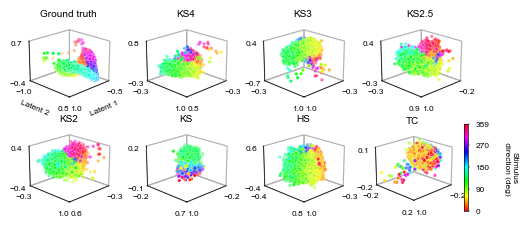

In [21]:
# (1m)
# setup figure
plt.set_cmap("hsv")  # circular cmap
TITLE_PAD = 0.3
pm = {
    "params": params_pca,
    "axis_lim": [-1.1, 1.1],
    "markersize": 6,
    "downsample": 1,
}

fig = plt.figure(figsize=(5.8, 2.5))

# -------  plot full gt responses ---------

# note: we take all the responses so
# no source of variability
# panel 1: ground truth
ax = fig.add_subplot(2, 4, 1, projection="3d")
manifold = plot_manifold_from_pca(ax, response_full_gt, **pm)
ax.set_title("Ground truth", pad=0.8)
ax.set_xlabel("Latent 1", labelpad=-10)
ax.set_ylabel("Latent 2", labelpad=-10)
ax.set_zlabel("Latent 3", labelpad=-5)
print("N=:", response_full_gt.shape[0])

# ------- plot ks4 responses ---------

# note: we sample the responses so
# embedding can change with response seed
# note: we sample the responses so
# embedding can change with response seed
ax = fig.add_subplot(2, 4, 2, projection="3d")
manifold = plot_manifold_from_pca(ax, response_k4, **pm)
ax.set_title("KS4", pad=TITLE_PAD)
print("N=:", response_k4.shape[0])

# ------- plot ks3 responses ---------

# note: we sample the responses so
# embedding can change with response seed
# note: we sample the responses so
# embedding can change with response seed
ax = fig.add_subplot(2, 4, 3, projection="3d")
manifold = plot_manifold_from_pca(ax, response_k3, **pm)
ax.set_title("KS3", pad=TITLE_PAD)
print("N=:", response_k3.shape[0])

# ------- plot ks2.5 responses ---------

# note: we sample the responses so
# embedding can change with response seed
# note: we sample the responses so
# embedding can change with response seed
ax = fig.add_subplot(2, 4, 4, projection="3d")
manifold = plot_manifold_from_pca(ax, response_k25, **pm)
ax.set_title("KS2.5", pad=TITLE_PAD)
print("N=:", response_k25.shape[0])

# ------- plot ks2 responses ---------

# note: we sample the responses so
# embedding can change with response seed
# note: we sample the responses so
# embedding can change with response seed
ax = fig.add_subplot(2, 4, 5, projection="3d")
manifold = plot_manifold_from_pca(ax, response_k2, **pm)
ax.set_title("KS2", pad=TITLE_PAD)
print("N=:", response_k2.shape[0])

# ------- plot ks responses ---------

# note: we sample the responses so
# embedding can change with response seed
# note: we sample the responses so
# embedding can change with response seed
ax = fig.add_subplot(2, 4, 6, projection="3d")
manifold = plot_manifold_from_pca(ax, response_ks, **pm)
ax.set_title("KS", pad=TITLE_PAD)
print("N=:", response_ks.shape[0])

# ------- plot hs responses ---------

# note: we sample the responses so
# embedding can change with response seed
# note: we sample the responses so
# embedding can change with response seed
ax = fig.add_subplot(2, 4, 7, projection="3d")
manifold = plot_manifold_from_pca(ax, response_hs, **pm)
ax.set_title("HS", pad=TITLE_PAD)
print("N=:", response_hs.shape[0])


# ------- plot threshold crossing responses ---------

# note: we sample the responses so
# embedding can change with response seed
# note: we sample the responses so
# embedding can change with response seed
ax = fig.add_subplot(2, 4, 8, projection="3d")
manifold = plot_manifold_from_pca(ax, response_tc, **pm)
ax.set_title("TC", pad=TITLE_PAD)
print("N=:", response_tc.shape[0])

# ------- Legend ---------

# colorbar
cbar = plt.colorbar(
    manifold["scat"], ticks=[0, 90, 180, 270, 359], fraction=0.05, pad=0.1
)
cbar.ax.set_yticklabels([0, 90, 180, 270, 359])
cbar.ax.set_ylabel("Stimulus\n direction (deg)", rotation=270, labelpad=20)

# clear space
# plt.tight_layout(pad=0, h_pad=0, w_pad=0)

# # save
# utils.savefig(
#     proj_path + "/figures/4_code/fig7A_pca_manifolds_vs_sorter.svg",
# )

# # save
# utils.savefig_with_params(
#     proj_path + "/figures/4_code/fig7A_pca_manifolds_vs_sorter.png",
#     dpi=600,
#     transparent=True,
# )

### Manifolds vs. sampling biases

manifold axis max: 1.0
manifold axis min: -0.9765924801422974
N=: 1836
manifold axis max: 1.0
manifold axis min: -0.6243333161888311
N=: 354
manifold axis max: 1.0
manifold axis min: -0.35394922553616454
N=: 354


<Figure size 200x100 with 0 Axes>

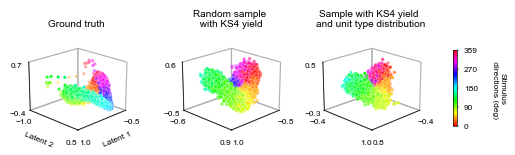

In [22]:
# (1m)
# setup figure
plt.set_cmap("hsv")  # circular cmap

fig = plt.figure(figsize=(5.2, 1.5))

# -------  plot full gt responses ---------

# note: we take all the responses so
# no source of variability
# panel 1: ground truth
ax = fig.add_subplot(1, 3, 1, projection="3d")
manifold = plot_manifold_from_pca(ax, response_full_gt, **pm)
ax.set_title("Ground truth")
ax.set_xlabel("Latent 1", labelpad=-10)
ax.set_ylabel("Latent 2", labelpad=-10)
ax.set_zlabel("Latent 3", labelpad=-5)
print("N=:", response_full_gt.shape[0])

# ------- plot subsampling yield responses ---------

# note: we sample the responses so
# embedding can change with response seed
ax = fig.add_subplot(1, 3, 2, projection="3d")
manifold = plot_manifold_from_pca(ax, response_rand_k4_yield, **pm)
ax.set_title("Random sample\n with KS4 yield")
print("N=:", response_rand_k4_yield.shape[0])

# ------- plot ks4 subsampling bias responses ---------

# note: we sample the responses so
# embedding can change with response seed
# note: we sample the responses so
# embedding can change with response seed
ax = fig.add_subplot(1, 3, 3, projection="3d")
manifold = plot_manifold_from_pca(ax, response_biased_as_k4, **pm)
ax.set_title("Sample with KS4 yield \nand unit type distribution")
print("N=:", response_biased_as_k4.shape[0])

# colorbar
cbar = plt.colorbar(
    manifold["scat"], ticks=[0, 90, 180, 270, 359], fraction=0.026, pad=0.2
)
cbar.ax.set_yticklabels([0, 90, 180, 270, 359])
cbar.ax.set_ylabel("Stimulus\n directions (deg)", rotation=270, labelpad=20)

# clear space
plt.tight_layout()

# # save
# utils.savefig(
#     proj_path + "/figures/4_code/fig7C_pca_manifolds_vs_sampling.svg",
# )

# # save
# utils.savefig_with_params(
#     proj_path + "/figures/4_code/fig7C_pca_manifolds_vs_sampling.png",
#     dpi=600,
#     transparent=True,
# )